# Q1 

$\theta$ update:

We propose a new $\theta$ using a normal random-walk and accept it with probability: 
$$

\min\Bigl(1, \frac{p(\mathbf{x}|\tilde\theta,\tau)\,p(\tilde\theta)}{p(\mathbf{x}|\theta,\tau)\,p(\theta)}\Bigr),

$$

$\tau$ update:

We propose a new $\tau$ from its prior. Because the proposal equals the prior, the ratio of priors and proposal densities cancel in the acceptance probability. Thus, only the likelihood terms $p(\mathbf{x}|\theta,\tau) \propto \tau^{n/2}\exp\Bigl\{-\frac{\tau}{2}\sum (x_i-\theta)^2\Bigr\}$ are needed. 

In contrast to previous Gibbs sampler which used the full conditional distributions, this metropolis within gibbs sampler approach only requires evaluating the joint density (up to proportionality). This approach can be used when the full conditionals are difficult to compute. 



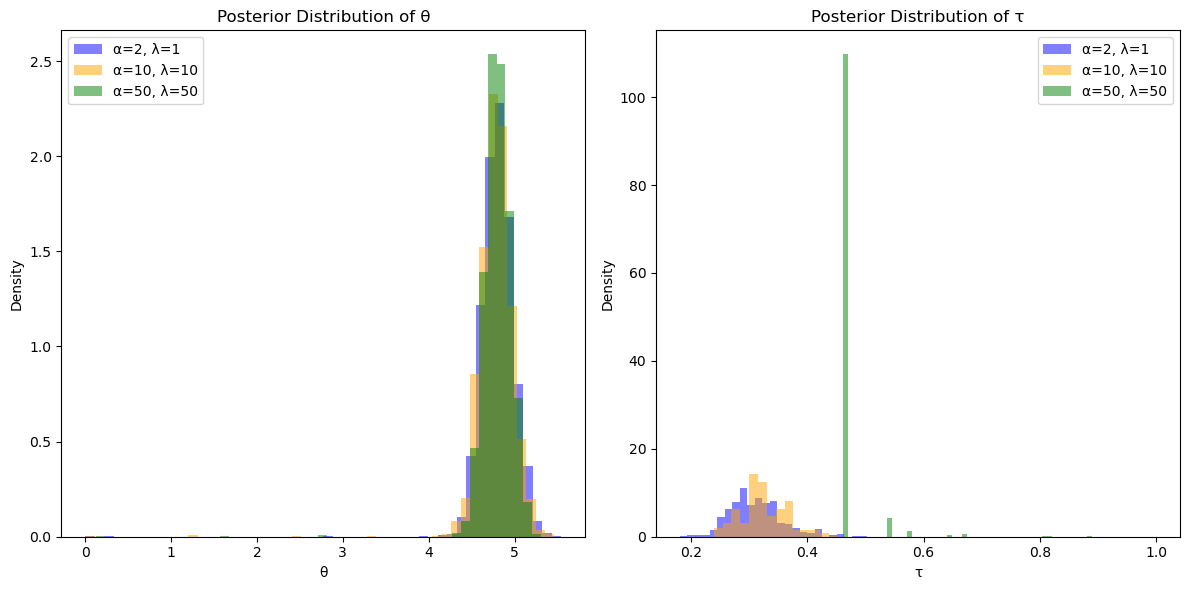

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def metropolis_within_gibbs_sampler_q2(x, num_iterations, init_theta, init_tau,
                                       theta_0, tau_0, alpha, lambda_,
                                       proposal_var_theta=1.0):
    """
    Metropolis-within-Gibbs sampler for the model:
    
       x_i | θ,τ ~ N(θ, 1/τ),   for i = 1, ..., n,
       θ ~ N(θ₀, τ₀)  and  τ ~ Gamma(α/2, rate=λ/2).
       
    The joint (up to constants) is:
    
       p(θ,τ|x) ∝ τ^(n/2) exp{ -τ/2 Σ (x_i-θ)² }
                    × exp{ - (θ-θ₀)²/(2τ₀) }
                    × τ^(α/2 -1) exp{ -λτ/2 }.
    
    We update θ and τ using separate Metropolis-Hastings steps:
    
      1. **θ update:** 
         - Proposal:  θ* ~ N(θ^(t-1), proposal_var_theta)
         - Acceptance ratio uses only terms in the joint that depend on θ:
           exp{ -τ/2 Σ (x_i-θ)² } × exp{ - (θ-θ₀)²/(2τ₀) }.
           
      2. **τ update:** 
         - Proposal:  τ* ~ Gamma(α/2, scale=2/λ) (i.e. using the prior as the proposal).
         - Because the proposal equals the prior, the acceptance ratio is given by 
           the ratio of likelihoods:
           τ^(n/2) exp{ -τ/2 Σ (x_i-θ)² }.
    
    Parameters:
      x               : observed data (1-D array)
      num_iterations  : number of MCMC iterations
      init_theta, init_tau : initial values for θ and τ
      theta_0, tau_0  : hyperparameters for the θ prior
      alpha, lambda_  : hyperparameters for the τ prior (Gamma)
      proposal_var_theta : variance of the normal proposal for θ
      
    Returns:
      theta_samples, tau_samples : arrays of samples for θ and τ
    """
    n = len(x)
    theta_samples = []
    tau_samples = []
    theta = init_theta
    tau = init_tau

    for _ in range(num_iterations):
        theta_prop = np.random.normal(theta, np.sqrt(proposal_var_theta))
        
        log_target_theta_current = -0.5 * tau * np.sum((x - theta)**2) \
                                     - ((theta - theta_0)**2) / (2 * tau_0)
        log_target_theta_prop    = -0.5 * tau * np.sum((x - theta_prop)**2) \
                                     - ((theta_prop - theta_0)**2) / (2 * tau_0)
        log_ratio_theta = log_target_theta_prop - log_target_theta_current
        
        if np.log(np.random.rand()) < log_ratio_theta:
            theta = theta_prop

        tau_prop = np.random.gamma(shape=alpha/2, scale=2/lambda_)
        
        sum_sq = np.sum((x - theta)**2)
        log_lik_tau_current = (n/2)*np.log(tau) - 0.5*tau*sum_sq
        log_lik_tau_prop    = (n/2)*np.log(tau_prop) - 0.5*tau_prop*sum_sq
        log_ratio_tau = log_lik_tau_prop - log_lik_tau_current
        
        if np.log(np.random.rand()) < log_ratio_tau:
            tau = tau_prop

        theta_samples.append(theta)
        tau_samples.append(tau)
        
    return np.array(theta_samples), np.array(tau_samples)


np.random.seed(42)
x = np.random.normal(5, 2, 100)

results = {}
for alpha_val, lambda_val in [(2, 1), (10, 10), (50, 50)]:
    theta_samples, tau_samples = metropolis_within_gibbs_sampler_q2(
        x, num_iterations=5000,
        init_theta=0, init_tau=1,
        theta_0=5, tau_0=1,
        alpha=alpha_val, lambda_=lambda_val,
        proposal_var_theta=1.0
    )
    results[(alpha_val, lambda_val)] = (theta_samples, tau_samples)

plt.figure(figsize=(12, 6))
colors = ['blue', 'orange', 'green']
labels = ["α=2, λ=1", "α=10, λ=10", "α=50, λ=50"]

for i, ((alpha_val, lambda_val), (theta_samples, tau_samples)) in enumerate(results.items()):
    plt.subplot(1, 2, 1)
    plt.hist(theta_samples, bins=50, density=True, alpha=0.5, 
             color=colors[i], label=labels[i])
    plt.xlabel("θ")
    plt.ylabel("Density")
    plt.title("Posterior Distribution of θ")
    
    plt.subplot(1, 2, 2)
    plt.hist(tau_samples, bins=50, density=True, alpha=0.5, 
             color=colors[i], label=labels[i])
    plt.xlabel("τ")
    plt.ylabel("Density")
    plt.title("Posterior Distribution of τ")

plt.subplot(1, 2, 1)
plt.legend()
plt.subplot(1, 2, 2)
plt.legend()
plt.tight_layout()
plt.show()

# Q2

For $\tau$, instead of using an independent proposal, we now use a dependent proposal that "centers" on the current value using a truncated normal distribution. This proposal only generates positive values and nudges $\tau$ from its current value. Because the proposal isn't symmetric, we must include the Hastings ratio in the acceptance probability. 
For $\theta$, we now assume a non normal prior: the double exponential distribution: $p(\theta) \propto exp(-\frac{|\theta - \theta_0|}{b})$. It was chosen since it's a common heavy-tailed alternative. 

The joint density is: 
$$p(\mathbf{x},\theta,\tau)
\propto \tau^{n/2}\exp\Bigl\{-\frac{\tau}{2}\sum_{i=1}^n (x_i-\theta)^2\Bigr\}
\;\exp\Bigl\{-\frac{|\theta-\theta_0|}{b}\Bigr\}\;
\tau^{\alpha/2-1}\exp\Bigl\{-\frac{\lambda}{2}\tau\Bigr\}\,$$








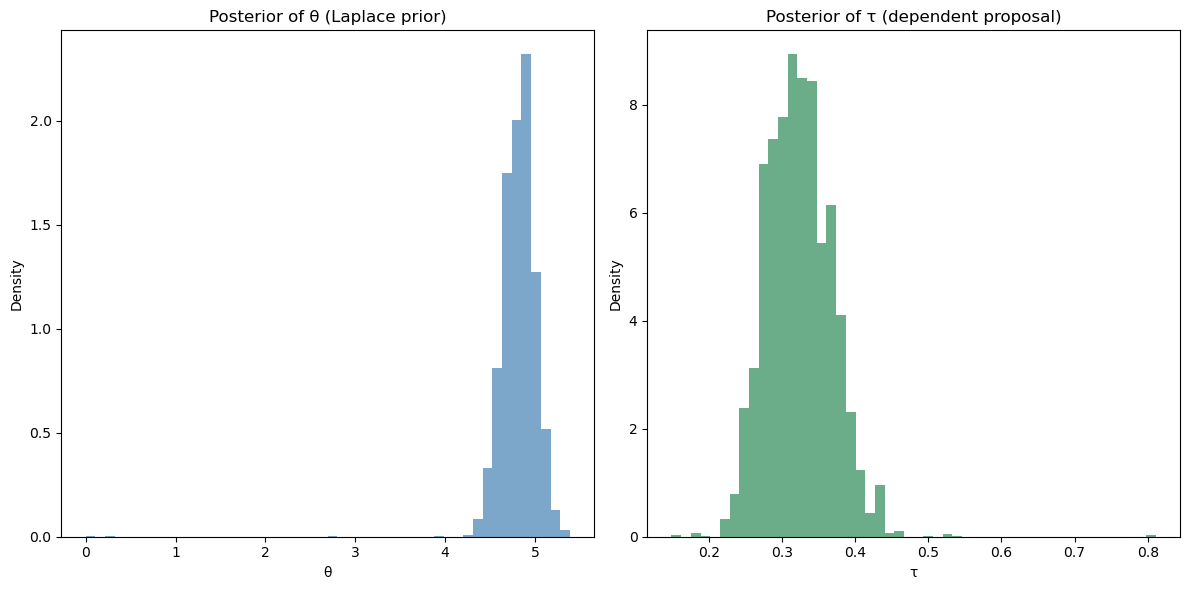

In [ ]:
from scipy.stats import truncnorm

def metropolis_within_gibbs_sampler_dep(x, num_iterations, init_theta, init_tau,
                                          theta_0, b, alpha, lambda_, s,
                                          proposal_var_theta=1.0):
    """
    Metropolis-within-Gibbs sampler for the model:
    
      - Likelihood:   x_i | θ,τ ~ N(θ, 1/τ)
      - Prior for θ:  Laplace with location θ₀ and scale parameter b,
                      i.e.,  p(θ) ∝ exp(-|θ-θ₀|/b)
      - Prior for τ:  Gamma(α/2, rate=λ/2), i.e.,
                      p(τ) ∝ τ^(α/2 - 1) exp(-λτ/2)

    Parameters:
      x               : 1-D array of observed data
      num_iterations  : Number of MCMC iterations
      init_theta, init_tau : Initial values for θ and τ
      theta_0         : Location parameter for the Laplace prior on θ
      b               : Scale parameter for the Laplace prior on θ
      alpha, lambda_  : Hyperparameters for the Gamma prior on τ (shape=α/2, rate=λ/2)
      s               : Scale parameter for the τ proposal (truncated normal)
      proposal_var_theta : Variance for the θ random-walk proposal
      
    Returns:
      theta_samples, tau_samples : Arrays of MCMC samples for θ and τ
    """
    n = len(x)
    theta_samples = []
    tau_samples = []
    theta = init_theta
    tau = init_tau

    for _ in range(num_iterations):
        theta_prop = np.random.normal(theta, np.sqrt(proposal_var_theta))
        log_target_theta_current = -0.5 * tau * np.sum((x - theta)**2) - np.abs(theta - theta_0)/b
        log_target_theta_prop    = -0.5 * tau * np.sum((x - theta_prop)**2) - np.abs(theta_prop - theta_0)/b
        log_ratio_theta = log_target_theta_prop - log_target_theta_current

        if np.log(np.random.rand()) < log_ratio_theta:
            theta = theta_prop

        a_current = -tau/s
        tau_prop = truncnorm.rvs(a=a_current, b=np.inf, loc=tau, scale=s)
        sum_sq = np.sum((x - theta)**2)
        log_target_tau_current = (n/2 + alpha/2 - 1)*np.log(tau) - 0.5*tau*(sum_sq + lambda_)
        log_target_tau_prop    = (n/2 + alpha/2 - 1)*np.log(tau_prop) - 0.5*tau_prop*(sum_sq + lambda_)

        q_forward = truncnorm.pdf(tau_prop, a=a_current, b=np.inf, loc=tau, scale=s)
        a_prop = -tau_prop/s
        q_reverse = truncnorm.pdf(tau, a=a_prop, b=np.inf, loc=tau_prop, scale=s)

        log_ratio_tau = (log_target_tau_prop - log_target_tau_current +
                         np.log(q_reverse) - np.log(q_forward))
        if np.log(np.random.rand()) < log_ratio_tau:
            tau = tau_prop

        theta_samples.append(theta)
        tau_samples.append(tau)

    return np.array(theta_samples), np.array(tau_samples)

np.random.seed(42)
x = np.random.normal(5, 2, 100)

# Hyperparameters and tuning parameters:
theta_0 = 5      # Laplace prior location for θ
b = 1.0          # Laplace prior scale for θ
alpha = 10       # For τ's Gamma prior (shape parameter α/2)
lambda_ = 10     # For τ's Gamma prior (rate parameter λ/2)
init_theta = 0   # Initial θ value
init_tau = 1     # Initial τ value
proposal_var_theta = 1.0  # Variance for the θ proposal
s = 0.5          # Scale for the truncated normal proposal for τ

num_iterations = 5000

theta_samples, tau_samples = metropolis_within_gibbs_sampler_dep(
    x, num_iterations, init_theta, init_tau,
    theta_0, b, alpha, lambda_, s, proposal_var_theta
)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(theta_samples, bins=50, density=True, alpha=0.7, color='steelblue')
plt.xlabel("θ")
plt.ylabel("Density")
plt.title("Posterior of θ (Laplace prior)")

plt.subplot(1, 2, 2)
plt.hist(tau_samples, bins=50, density=True, alpha=0.7, color='seagreen')
plt.xlabel("τ")
plt.ylabel("Density")
plt.title("Posterior of τ (dependent proposal)")

plt.tight_layout()
plt.show()

# Q3

**Given:**

- **Proposal:**  
  $$
  q(\tilde{x}\mid x)=\left(\tfrac{1}{2}\right)^{1-\tilde{x}}\left(\tfrac{1}{2}\right)^{\tilde{x}}
  $$
  so that $q(0\mid x)=q(1\mid x)=\tfrac{1}{2}$ (for any current state $x$).

- **Target Distribution:**  
  $$
  p(x)=\left(\tfrac{1}{3}\right)^{1-x}\left(\tfrac{2}{3}\right)^x,
  $$
  i.e., $p(0)=\tfrac{1}{3}$ and $p(1)=\tfrac{2}{3}.$

**Metropolis–Hastings Acceptance Rule:**  
Since the proposal is symmetric, the acceptance probability for a move \(x\to\tilde{x}\) is
$$
A(x\to \tilde{x})=\min\Bigl\{1,\frac{p(\tilde{x})}{p(x)}\Bigr\}.
$$

**Case 1: Current State \(x=0\)**
- If $\tilde{x}=0$:
  $$
  A(0\to0)=\min\{1,\,p(0)/p(0)\} = 1, \quad P(0\to0)=\tfrac{1}{2}\times1=0.5.
  $$
- If $\tilde{x}=1\$:
  $$
  A(0\to1)=\min\{1,\,p(1)/p(0)\}=\min\{1,(2/3)/(1/3)\}=1, \quad P(0\to1)=\tfrac{1}{2}\times1=0.5.
  $$

**Case 2: Current State \(x=1\)**
- If $\tilde{x}=1$:
  $$
  A(1\to1)=\min\{1,\,p(1)/p(1)\}=1, \quad P(1\to1)=\tfrac{1}{2}\times1=0.5.
  $$
- If $\tilde{x}=0$:
  $$
  A(1\to0)=\min\{1,\,p(0)/p(1)\}=\min\{1,(1/3)/(2/3)\}=0.5, \quad P(1\to0)=\tfrac{1}{2}\times0.5=0.25.
  $$
  
Since a rejected proposal results in staying in the same state, the overall probability for $x=1$ is:
$$
P(1\to1)=\underbrace{\tfrac{1}{2}}_{\text{propose }1}+\underbrace{\tfrac{1}{2}\times(1-0.5)}_{\text{propose }0\text{ but reject}}=0.5+0.25=0.75.
$$

**Thus, the Transition Kernel \(K\) is:**

$$
K=\begin{pmatrix}
\Pr(0\to0) & \Pr(1\to0)\\[1mm]
\Pr(0\to1) & \Pr(1\to1)
\end{pmatrix}
=\begin{pmatrix}
0.5 & 0.25\\[1mm]
0.5 & 0.75
\end{pmatrix}.
$$
  
This means that if the chain is at 0, it moves to 1 with probability 0.5 (and stays at 0 with probability 0.5), while if it is at 1, it moves to 0 with probability 0.25 (and stays at 1 with probability 0.75). These transition probabilities imply geometric waiting times with expected runs of 2 zeros and 4 ones, yielding the target stationary distribution \(p(0)=1/3\) and \(p(1)=2/3\).


Transition Kernel K:
[[0.5  0.25]
 [0.5  0.75]]


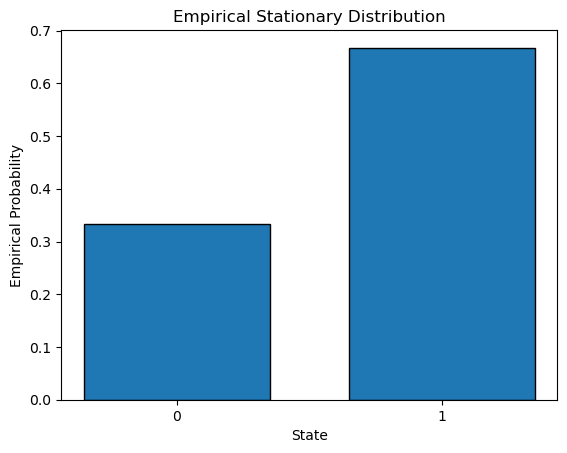

In [6]:
# Target probabilities:
p0, p1 = 1/3, 2/3

# Proposal: q(x|y) = 0.5 for both states.
q = 0.5

# Acceptance probabilities:
A_0to1 = min(1, p1/p0)  # = min(1, (2/3)/(1/3)) = 1.
A_1to0 = min(1, p0/p1)  # = min(1, (1/3)/(2/3)) = 0.5.

# Transition probabilities:
P0_to_0 = q * 1      # 0 -> 0: proposal 0 is accepted.
P0_to_1 = q * 1      # 0 -> 1: proposal 1 is accepted.
P1_to_0 = q * A_1to0 # 1 -> 0.

# For state 1, if proposal of 0 is rejected, the chain stays in 1.
P1_to_1 = q * 1 + q * (1 - A_1to0)  # 0.5 + 0.5*(0.5) = 0.75.

# Assemble the transition kernel:
K = np.array([[P0_to_0, P1_to_0],
              [P0_to_1, P1_to_1]])
print("Transition Kernel K:")
print(K)

# Simulation of the Markov Chain:
def mh_chain(n_steps, init=0):
    chain = [init]
    current = init
    for _ in range(n_steps):
        # Propose a new state uniformly (0 or 1)
        proposal = np.random.choice([0, 1])
        if current == 0:
            A = 1  # both proposals accepted when at 0.
        else:  # current == 1:
            A = 1 if proposal == 1 else 0.5
        # Accept or reject:
        if np.random.rand() < A:
            current = proposal
        chain.append(current)
    return np.array(chain)

np.random.seed(42)
chain = mh_chain(10000, init=0)
plt.hist(chain, bins=[-0.5, 0.5, 1.5], density=True, edgecolor='k', rwidth=0.7)
plt.xticks([0, 1])
plt.xlabel("State")
plt.ylabel("Empirical Probability")
plt.title("Empirical Stationary Distribution")
plt.show()